# Semantic Text Clustering with HDBSCAN

In [1]:
import pandas as pd

# Load responses
df = pd.read_csv("FS_output/run_7_gpt-5.csv")  # Replace with your file
df.head()

,game_id,human_verdict,confidence,reason,conversation_A_transcript,conversation_B_transcript,label_A,label_B,who_is_human,ai_model,human_correct,aijudge_verdict,human_characteristics,elapsed_time
0,1852,A,-100,texted like an average college student,"I: Hello, how are you today?\nW: im doing good...","I: Hello, how are you today?\nW: Hi. What seem...",Human,eliza,A,eliza,True,A,"[\n ""Shares recent personal details."",\n ""En...",14.477205
1,2597,B,100,We discussed many realistic things,I: Do you eat chicken?\nW: You're not really t...,"I: Do you eat chicken?\nW: Yes, but beef is my...",eliza,Human,B,eliza,True,B,"[\n ""Gives direct answers with specific perso...",15.804978
2,1768,B,100,Spoke like AI and did not make sense,I: hey\nW: Hi\nI: what's your name\nW: <NAME>\...,I: hey\nW: What does that suggest to you?\nI: ...,Human,eliza,A,eliza,False,A,"[\n ""Shares concrete personal details and loc...",16.872617
3,2937,B,40,this one was tough. witness a was trying hard ...,I: hey buddy.\nW: What does that suggest to yo...,I: hey buddy.\nW: Xup man\nI: you a guy or gir...,eliza,Human,B,eliza,True,B,"[\n ""Gives direct answers about self and shar...",18.849975
4,1938,A,-94,Witness B made literally zero sense and it was...,I: Hi there\nW: Hellooo!\nI: What have you bee...,I: Hey there\nW: What does that suggest to you...,Human,eliza,A,eliza,True,A,"[\n ""Provides concrete personal preferences a...",19.264441


## Human accuracy

In [2]:
output = df.copy()

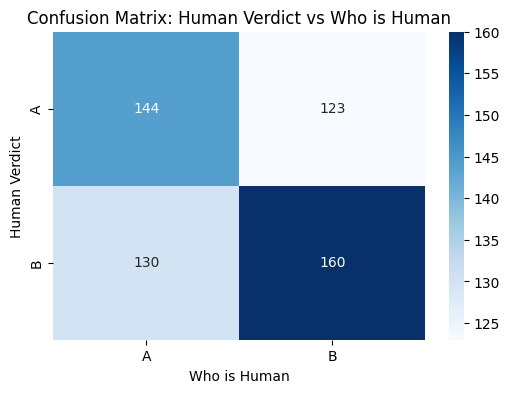

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

cm = pd.crosstab(output["human_verdict"], output["who_is_human"],
                 rownames=["Human Verdict"], colnames=["Who is Human"])

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix: Human Verdict vs Who is Human")
plt.shGroup 1: voice & texting vibe
0. Keeps replies brief and casual without over-explaining.
1. Uses casual slang, abbreviations, and shorthand naturally.
2. Uses lowercase texting style.
3. Shows small typos, uneven punctuation, and informal grammar typical of quick texting.
4. Uses emojis, emoticons, and playful elongations.
5. Uses casual, playful humor.
6. Tone feels spontaneous, unforow()

In [4]:
sum(output["human_verdict"] == output["who_is_human"])/len(output)

0.5457809694793537

In [5]:
from sklearn.metrics import f1_score

# Calculate F1 score for AI judge's verdict
# We need to convert the labels to numerical format for f1_score
output['who_is_human_numeric'] = output['who_is_human'].apply(lambda x: 1 if x == 'A' else 0)
output['human_verdict_numeric'] = output['human_verdict'].apply(lambda x: 1 if x == 'A' else 0)

f1 = f1_score(output['who_is_human_numeric'], output['human_verdict_numeric'])

print(f"F1 Score for Human Judge's Verdict: {f1}")

F1 Score for Human Judge's Verdict: 0.532347504621072


In [7]:
output = output[output["aijudge_verdict"].isin(["A", "B"])].copy()
len(output)

557

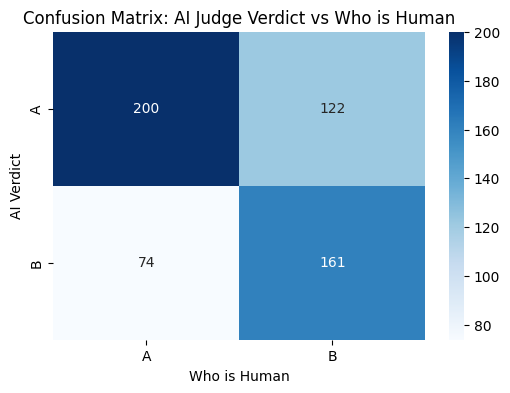

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

cm = pd.crosstab(output["aijudge_verdict"], output["who_is_human"],
                 rownames=["AI Verdict"], colnames=["Who is Human"])

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix: AI Judge Verdict vs Who is Human")
plt.show()

In [9]:
sum(output["aijudge_verdict"] == output["who_is_human"])/len(output)

0.6481149012567325

## Collect all statements

In [13]:
import json

In [14]:
df.columns

Index(['game_id', 'human_verdict', 'confidence', 'reason',
       'conversation_A_transcript', 'conversation_B_transcript', 'label_A',
       'label_B', 'who_is_human', 'ai_model', 'human_correct',
       'aijudge_verdict', 'human_characteristics', 'elapsed_time'],
      dtype='object')

In [15]:
json.loads(df['human_characteristics'][0])

['Shares recent personal details.',
 'Engages in friendly back-and-forth and asks about the other person.',
 'Responds relevantly and maintains context.',
 'Uses casual slang and natural tone.',
 'Avoids canned, repetitive or deflective questions.']

In [16]:
all_statements = []
likert_verdict = []

for i in range(len(df)):
    statement_list = json.loads(df['human_characteristics'][i])
    a_total_score = 0
    b_total_score = 0
    for item in statement_list:
        all_statements.append(item)

print(all_statements[:10])

['Shares recent personal details.', 'Engages in friendly back-and-forth and asks about the other person.', 'Responds relevantly and maintains context.', 'Uses casual slang and natural tone.', 'Avoids canned, repetitive or deflective questions.', 'Gives direct answers with specific personal preferences.', 'Shares small self-disclosures like cravings or habits.', 'Uses casual tone and playful markers, including brand-specific details.', 'Asks relevant, reciprocal follow-up questions.', 'Maintains natural flow instead of deflecting with vague or reflective prompts.']


# Clustering

In [17]:
print(f"The average number of items in aijudge_reason is: {len(all_statements)/len(df):.2f}")

The average number of items in aijudge_reason is: 4.91


In [18]:
import ast

print(f"Total number of statements: {len(all_statements)}")

Total number of statements: 2735


Install the required libraries:

## 1  Prepare your texts and embed them

In [20]:
from sentence_transformers import SentenceTransformer
import numpy as np
import umap, hdbscan
from sklearn.feature_extraction.text import TfidfVectorizer

model = SentenceTransformer("all-MiniLM-L6-v2")  # lightweight & fast

statement_embeddings = model.encode(all_statements, normalize_embeddings=True)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

## 2  (Optional) Reduce dimensionality with UMAP

In [ ]:
len(all_statements)

2735

In [26]:
reduced_statements = umap.UMAP(
    n_neighbors=15,
    n_components=5,
    metric="cosine",
).fit_transform(statement_embeddings)

## 3  Cluster the embeddings with HDBSCAN

In [27]:
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=10,  # tweak for broader vs finer themes
    metric="euclidean",
)
statement_labels = clusterer.fit_predict(reduced_statements)

/localdisk3/miniconda/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/localdisk3/miniconda/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


scikit-learnscikit-learnscikit-learnscikit-learnscikit-learnscikit-learnscikit-learnscikit-learnscikit-learn## 3.5 visualize

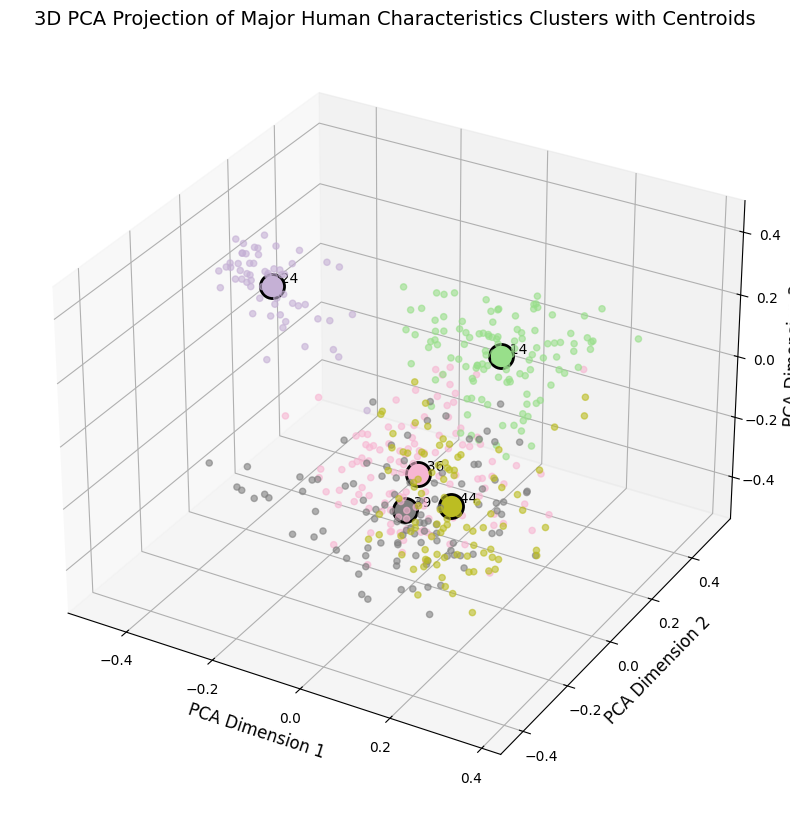

In [28]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
# import matplotlib.colormaps as cm # Removed the problematic import

# Reduce dimensionality with PCA for 3D visualization
pca = PCA(n_components=3)  # Reduce to 3 dimensions for 3D plotting
reduced_statement_pca = pca.fit_transform(statement_embeddings)

# Visualize the clusters
fig = plt.figure(figsize=(12, 10)) # Increased figure size
ax = fig.add_subplot(111, projection='3d')

# Get unique human cluster labels and their counts
unique_labels, counts = np.unique(statement_labels, return_counts=True)

# Sort labels by count in descending order
sorted_labels = unique_labels[np.argsort(-counts)]

# Select a few major clusters (e.g., top 5, excluding noise label -1)
major_clusters = [label for label in sorted_labels if label != -1][:5]

# Get the colormap used for the clusters using the older method
cmap = plt.get_cmap('tab20', len(unique_labels))


# Plot major human clusters and their centroids
for i, label in enumerate(major_clusters):
    indices = np.where(statement_labels == label)
    cluster_color = cmap(np.where(unique_labels == label)[0][0]) # Get the color for this label
    ax.scatter(reduced_statement_pca[indices, 0], reduced_statement_pca[indices, 1], reduced_statement_pca[indices, 2], label=f'Cluster {label}', s=20, alpha=0.6, color=cluster_color) # Increased marker size, added transparency

    # Calculate and plot centroid with the same color
    centroid = reduced_statement_pca[indices].mean(axis=0)
    ax.scatter(centroid[0], centroid[1], centroid[2], marker='o', color=cluster_color, s=300, edgecolors='black', linewidth=2) # Centroid color is now the same as cluster color, increased size
    ax.text(centroid[0], centroid[1], centroid[2], f'  {label}', color='black', ha='left', va='bottom', fontsize=10) # Increased font size for label


ax.set_title('3D PCA Projection of Major Human Characteristics Clusters with Centroids', fontsize=14) # Increased title font size
ax.set_xlabel('PCA Dimension 1', fontsize=12) # Increased label font size
ax.set_ylabel('PCA Dimension 2', fontsize=12) # Increased label font size
ax.set_zlabel('PCA Dimension 3', fontsize=12) # Increased label font size
ax.grid(True, linestyle='--', alpha=0.5) # Added grid lines
# ax.legend() # Removed legend
plt.show()

## 4  Inspect clusters

In [29]:
from collections import defaultdict

statement_groups = defaultdict(list)
for txt, lab in zip(all_statements, statement_labels):
    statement_groups[lab].append(txt)

print("=== Raw clusters ===")
for lab, items in statement_groups.items():
    print(f"\nCluster {lab}:")
    if lab == -1:
        continue
    for t in items:
        print("  •", t)

=== Raw clusters ===

Cluster 51:
  • Shares recent personal details.
  • Gives specific personal details that stay consistent.
  • Shares concrete personal details quickly and casually.
  • Shares specific, concrete personal details.
  • Shares specific, consistent personal details tied to the topic.
  • Shares concrete personal details when asked.
  • Provides a specific personal detail when prompted, rather than a generic persona claim.
  • Shares small, specific personal details about recent activities.
  • Shares mundane personal details casually without over-explaining.
  • Shares small personal details that fit the context.
  • Shares quirky, concrete details with exact counts.
  • Shares concrete, personal details rather than safe, generic ones.
  • Shares small, specific details without crafting a polished persona.
  • Shares small concrete personal details without over-explaining.
  • Shares small, concrete personal details without being asked.
  • Avoids unnecessary specific

# Pick k representative texts per cluster

In [30]:
import numpy as np

def representatives_k(texts, embeddings, labels, k=3):
    """
    Return {cluster_label: [k representative texts]}.
    Uses cosine-similarity to the cluster centroid.
    """
    reps = {}
    for lab in set(labels):
        if lab == -1:            # skip noise
            continue
        idx = np.where(labels == lab)[0]
        if len(idx) == 0:        # should never happen
            continue

        cluster_emb = embeddings[idx]
        centroid = cluster_emb.mean(axis=0)
        sims = cluster_emb @ centroid            # embeddings were L2-normalized
        top_k = idx[np.argsort(-sims)[:k]]       # k highest-similarity indices
        reps[lab] = [texts[i] for i in top_k]
    return reps

In [32]:
k = 3
statement_reps = representatives_k(all_statements, statement_embeddings, statement_labels, k)

cluster_string_statements = ""

for lab, samples in statement_reps.items():
    cluster_string_statements += f"\nCluster {lab} – {k} representatives:\n"
    for s in samples:
        cluster_string_statements += f"  • {s}\n"

print(cluster_string_statements)


Cluster 0 – 3 representatives:
  • Uses short, casual replies with slang and minimal punctuation.
  • Uses short, casual replies with slang and shorthand.
  • Gives short, casual replies with slang and small typos.

Cluster 1 – 3 representatives:
  • Maintains a consistent personal context across turns.
  • Maintains consistent personal context across turns.
  • Maintains coherent context and continuity across turns.

Cluster 2 – 3 representatives:
  • Tone feels casual and unforced rather than performative.
  • Tone is informal and unpolished rather than consistently upbeat and facilitative.
  • Tone feels spontaneous and opinionated rather than safely agreeable.

Cluster 3 – 3 representatives:
  • Avoids templated placeholders and gives concrete details.
  • Uses real, non-template details instead of placeholders.
  • Avoids template placeholders and uses real context.

Cluster 4 – 3 representatives:
  • Uses casual tone with natural slang, emojis, and elongations.
  • Uses a casual

# Find core idea using LLM

In [12]:
import os, getpass

def _set_env(var: str, reset=False):
    if not os.environ.get(var) or reset:
        os.environ[var] = getpass.getpass(f"{var}: ")

In [34]:
# _set_env("OPENAI_API_KEY", True)

OPENAI_API_KEY:  ········


## TinyAgent

In [16]:
import sys
import os
root_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
print(root_dir)
sys.path.append(root_dir)

from keys import *

/localdisk3/mhasan9/gpt-oss


In [17]:
import json
import tiktoken
from openai import OpenAI

client = OpenAI()

In [18]:
# @title
class TinyAgent:

    def __init__(self, model, tokenizer=None, debug=False):

        self.model = model
        self.messages = []
        self.max_tokens = 10072
        self.debug = False
        self.reasoning_effort = "low"
        self.temperature = 1

    def clear_messages(self):
        self.messages = list()

    def add_message(self,message_type, message):
        self.messages.append({"role": message_type, "content":message})

    def add_system_message(self, message):
        self.add_message("system", message)

    def add_user_message(self, message):
        self.add_message("user", message)

    def add_assistant_message(self, message):
        self.add_message("assistant", message)

    def add_instruction(self, instruction):
        self.add_system_message("Instruction:\n" + instruction)

    def add_data(self, data):
        self.add_system_message("Data:\n" + data)

    def set_max_tokens(self, max_tokens):
        self.max_tokens = max_tokens

    def set_debug(self, debug):
        self.debug = debug

    def set_reasoning_effort(self, reasoning_effort):
        self.reasoning_effort = reasoning_effort

    def call(self, prompt="", response_type="text", cache=True):
        messages = self.messages.copy()
        if prompt:
            messages.append({"role": "user", "content":prompt})
        if cache:
            self.add_user_message(prompt)

        if "gpt-5" in self.model:
            response = client.responses.create(
                model=self.model,
                input=messages,
                reasoning={"effort": self.reasoning_effort},
                text={
                    "format": {
                      "type": response_type
                    },
                    "verbosity": "low"
                  },
            )
            reply = response.output_text

        elif "gpt-4" in self.model or "o3" in self.model or "o4" in self.model:
            response = client.responses.create(
              model=self.model,
              input=messages,
              temperature=self.temperature,
              max_output_tokens=self.max_tokens,
              top_p=1,
              text={
                "format": {
                  "type": response_type # "text", "json_object"
                }
              }
            )
            reply = response.output_text
        if self.debug:
            print(reply)
        if cache:
            self.add_assistant_message(reply)
        return reply

    def load_json(self,s):
        import json
        try:
            return json.loads(s)
        except json.JSONDecodeError:
            return None

    def call_json(self, prompt=""):
        self.add_system_message("Reply must be JSON format.")
        reply = self.call(prompt=prompt, response_type="json_object")
        if not reply:
            print("Empty reply")
            return None

        reply = reply.strip()
        if reply.startswith("```json"):
            reply = reply[len("```json"):].strip()
            if reply.endswith("```"):
                reply = reply[:-3].strip()

        # Use OR, and guard length
        if not (reply.startswith("{") and reply.endswith("}")):
            print("Not JSON structure")
            return None

        try:
            return self.load_json(reply)
        except Exception:
            print("Error parsing JSON")
            return None

## Find important statements

In [37]:
tiny_agent = TinyAgent("gpt-5")
tiny_agent.set_reasoning_effort("high")

In [38]:
tiny_agent.add_data(cluster_string_statements)
tiny_agent.add_instruction("From the list of statement clusters of human characteristics, remove all redundant statements without losing any important information. Create a final list of distict statements that can help differentiate a human from AI. Output the following JSON format.")
tiny_agent.add_instruction("""Output format:
{
  "human_characteristics": [
    "statement1",
    "statement2",
    ...
  ]
}
""")
human_characteristics_final = tiny_agent.call_json()
human_characteristics_final

{'human_characteristics': ['Keeps replies brief and casual without over-explaining.',
  'Uses casual slang, abbreviations, and shorthand naturally.',
  'Uses lowercase texting style.',
  'Shows small typos, uneven punctuation, and informal grammar typical of quick texting.',
  'Uses emojis, emoticons, and playful elongations.',
  'Uses casual, playful humor.',
  'Makes niche cultural references from personal memory and assumes shared context.',
  'Tone feels spontaneous, unforced, and opinionated.',
  'Avoids formal, academic phrasing or technical formatting.',
  'Avoids templated placeholders and gives concrete, real details.',
  'Maintains a consistent personal context across turns.',
  "Builds on the other person's message and context.",
  'Clarifies ambiguous questions and self-corrects after clarification.',
  'Uses natural hedging and approximations; shows imperfect recall with hesitations and partial lists.',
  'Admits not knowing and asks to learn instead of inventing details.'

In [29]:
human_characteristics_final = human_characteristics_final["human_characteristics"]
len(human_characteristics_final)

TypeError: list indices must be integers or slices, not str

In [30]:
characteristics_string = ""

for (i, item) in enumerate(human_characteristics_final):
    characteristics_string += f"{i+1}. {item}\n"

In [31]:
print(characteristics_string)

1. Keeps replies brief and casual without over-explaining.
2. Uses casual slang, abbreviations, and shorthand naturally.
3. Uses lowercase texting style.
4. Shows small typos, uneven punctuation, and informal grammar typical of quick texting.
5. Uses emojis, emoticons, and playful elongations.
6. Uses casual, playful humor.
7. Makes niche cultural references from personal memory and assumes shared context.
8. Tone feels spontaneous, unforced, and opinionated.
9. Avoids formal, academic phrasing or technical formatting.
10. Avoids templated placeholders and gives concrete, real details.
11. Maintains a consistent personal context across turns.
12. Builds on the other person's message and context.
13. Clarifies ambiguous questions and self-corrects after clarification.
14. Uses natural hedging and approximations; shows imperfect recall with hesitations and partial lists.
15. Admits not knowing and asks to learn instead of inventing details.
16. Maintains context and answers directly; add

## Group statements

In [32]:
tiny_agent = TinyAgent("gpt-5")
tiny_agent.set_reasoning_effort("high")

tiny_agent.add_data("Statements:" + characteristics_string)
tiny_agent.add_instruction(f"From the list of statements, group them based on important themes. Re-order the {len(human_characteristics_final)} statements based on group. Number them from 1 to {len(human_characteristics_final)}")
tiny_agent.add_instruction("""Output format:
Group 1: ...
1. statement
2. statement
...
5. statement

Group 2: ..
6. statement
...
""")
groupped_statements = tiny_agent.call()

print(groupped_statements)

Group 1: Brevity & casual style
1. Keeps replies brief and casual without over-explaining.
2. Uses casual slang, abbreviations, and shorthand naturally.
3. Uses lowercase texting style.
4. Shows small typos, uneven punctuation, and informal grammar typical of quick texting.
5. Uses emojis, emoticons, and playful elongations.
6. Avoids formal, academic phrasing or technical formatting.
7. Uses natural, idiomatic phrasing.

Group 2: Voice, humor, and personal tone
8. Uses casual, playful humor.
9. Tone feels spontaneous, unforced, and opinionated.
10. Makes niche cultural references from personal memory and assumes shared context.
11. Explains choices with simple personal reasons and constraints.
12. Adds small personal emotions or judgments.
13. Shares idiosyncratic, niche preferences and activities instead of safe, generic picks.

Group 3: Honesty, uncertainty, and clarification
14. Clarifies ambiguous questions and self-corrects after clarification.
15. Uses natural hedging and approx